In [3]:


import matplotlib.pyplot as plt
from pathlib import Path
import neurokit2 as nk
from pathlib import Path
from scipy.io import loadmat
import scipy
import pandas as pd
import numpy as np
from scipy.signal import butter



In [4]:
class SignalProcessing(object):
    def __init__(self, data: dict):
        self.data = data

    def _get_data(self):
        pass

    def windows(self):
        pass

    def filt_by_fft(self):
        pass

    def get_interventions(self):
        pass

    def segment_signal(self, signal, fs, duration):
        nrow = fs*duration
        ncol = int(len(signal)/nrow)+1
        zeros = np.zeros(nrow*ncol)
        for i, _ in enumerate(signal, 0):
            zeros[i] = signal[i]
        return zeros.reshape((nrow, ncol))
    
    def bandpass_filter(self, order, signal, fs, low, high):
        sos = butter(N = order, Wn = [low, high], btype = "bandpass",fs = fs, output = 'sos')
        filtered = scipy.signal.sosfilt(sos, signal)
        return filtered

class RadarSignalProcessing(SignalProcessing):
    def __init__(self, data:dict, fs:int):
        super().__init__(data)
        self.fs = fs
        
    def get_radar_i(self):
        return self.data['radar_i']
    
    def get_radar_data(self):
        return self.data['radar_i'], self.data['radar_q']
    
    def complex_demodulation(self) -> np.array:
        radar_i, radar_q = self.get_radar_data()
        complex_fn = lambda a, b: complex(a, b)
        assert len(radar_i) == len(radar_q)
        complex_arr = [complex_fn(radar_i[i], radar_q[i]) for i in range(len(radar_i))]
        return np.array(complex_arr)
        
    def _signal_filter_powerline(signal, sampling_rate, powerline=50):
        if sampling_rate >= 100:
            b = np.ones(int(sampling_rate / powerline))
        else:
            b = np.ones(2)
        a = [len(b)]
        y = scipy.signal.filtfilt(b, a, signal, method="pad")
        return y
    
    @staticmethod
    def remove_dc_offset(radar_i, radar_q):
        return radar_i - radar_i.mean(), radar_q - radar_q.mean()
        
    

    def arctangent_signal(self) -> np.array:
        data = self.data
        radar_i = data['radar_i']
        radar_q = data['radar_q']
        assert len(radar_i) == len(radar_q)
        # radar_i = np.array([e if e > 0.00001 else 0.00001 for e in radar_i ], dtype=object)
        radar_i, radar_q = self.remove_dc_offset(radar_i, radar_q)
        demodulated_signal = []
        for i in range(len(radar_i)):
            demodulated_signal.append(np.arctan(radar_q[i]/radar_i[i]))
        
        return np.array(demodulated_signal)
    
    def imbalance_factor(self):
        """
        This function's used to find imbalance factor base on paper
        'Data-Based Quadrature Imbalance Compensation
        for a CW Doppler Radar System'
        input: radar_i, radar_q, sampling rate:fs
        output: 
        + alpha: amptitude imbalance
        + phi: angle imbalance
        """
        radar_i = self.data['radar_i']
        radar_q = self.data['radar_q']
        assert len(radar_i) == len(radar_q)
        multified_pair_arr = []
        for i in range(0, len(radar_i)):
            multified_pair_arr.append(radar_i[i]*radar_q[i])
        
        multified_pair_arr = np.array(multified_pair_arr, dtype=object)
        square_q_arr = np.array([e*e for e in radar_q], dtype=object)
        array_one = np.ones(len(radar_i))
        M = np.array([square_q_arr, multified_pair_arr, radar_i, radar_q, array_one], dtype='float32')
        M = M.T
        b = np.array([[e*e for e in radar_i]], dtype='float32')
        b = b.T
        term_1 = M.T@M
        inv_term_1 =np.linalg.inv(term_1)
        
        coefs = inv_term_1@M.T@b
        print(coefs)
        
        imbalance_amp = np.sqrt(1/np.abs(coefs[0]))
        imbalance_phi = np.arcsin(coefs[1]/(2*np.sqrt(np.abs(coefs[0]))))
        print(imbalance_amp, imbalance_phi)
        return imbalance_amp, imbalance_phi
    
    
    
    def correct_i_q(self):
        imbalance_amp, imbalance_phi = self._imbalance_factor()
        
        

class ReferenceSignalProcessing(SignalProcessing):
    def _clean_ecg(self) -> np.array:
        sr = self.data['fs_ecg']
        ecg = self.data['tfm_ecg']
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=sr)
        return ecg_cleaned, sr

    def get_z0(self) -> np.array:
        return self.data['tfm_z0']

    def resp_motion(self) -> list:
        data = self.data
        # icg = data['tfm_icg']
        z0 = self.get_z0()
        ecg_cleaned, sr_ecg = self._clean_ecg()
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sr_ecg)
        rate = nk.ecg_rate(rpeaks, sampling_rate=sr_ecg,
                           desired_length=len(ecg_cleaned))
        edr = nk.ecg_rsp(rate, sampling_rate=sr_ecg, method='charlton2016')
        return ecg_cleaned, edr, z0



In [2]:

def plot_in_duration(start, end, fs, *data):
    start = int(fs*start)
    end = int(fs*end)
    count = 1
    for n in data:
        ax = plt.subplot(len(data), 1, count)
        ax.plot(n[start:end], 'r.')
        count += 1
    plt.show()

data_normal_file = Path(
    'data/datasets_subject_01_to_10_scidata/GDN0007/GDN0007_1_Resting.mat')
data_apnea_file = Path(
    'data/datasets_subject_01_to_10_scidata/GDN0005/GDN0005_3_Apnea.mat')

target_fs = 100
data_apnea = loadmat(data_apnea_file)

fs_radar = data_apnea['fs_radar'][0][0]
fs_icg = data_apnea['fs_icg'][0][0]

fs_ecg = data_apnea['fs_ecg'][0][0]
fs_z0 = data_apnea['fs_z0'][0][0]

radar_i_apnea = data_apnea['radar_i']
radar_i_apnea = np.array([e[0] for e in radar_i_apnea])
radar_q_apnea = np.asarray(data_apnea['radar_q'])
radar_q_apnea = np.array([e[0] for e in radar_q_apnea])

tfm_icg = data_apnea['tfm_icg']
tfm_icg = np.array([e[0] for e in tfm_icg])
tfm_z0 = data_apnea['tfm_z0']
tfm_z0 = np.array([e[0] for e in tfm_z0])

data_normal = loadmat(data_normal_file)
radar_i_normal = data_normal['radar_i']
radar_i_normal = np.array([e[0]/1000 for e in radar_i_normal])
radar_q_normal = data_normal['radar_q']/1000
radar_q_normal = np.array([e[0]/1000 for e in radar_q_normal])

tfm_icg_normal = data_normal['tfm_icg']
tfm_z0_normal = data_normal['tfm_z0']
tfm_ecg_normal = data_normal['tfm_ecg1']


In [5]:
def resample(origin_data, origin_fs, target_fs):
    len_new_data = int(len(origin_data)*target_fs/origin_fs)+1
    new_data = np.zeros(len_new_data)
    for i, _ in enumerate(origin_data):
        index_of_new_data = int(i*target_fs/origin_fs)
        new_data[index_of_new_data] = origin_data[i]
    return new_data


def test_radar_signal():
    #prepare reference data.
    resampled_ecg = resample(tfm_ecg_normal, fs_ecg, target_fs)
    
    data = {'tfm_ecg': resampled_ecg,
            'tfm_z0': tfm_z0_normal,
            'tfm_icg': tfm_icg_normal,
            'fs_ecg': target_fs
            }

    ref_signal_processing = ReferenceSignalProcessing(data)
    resp_signal, edr, z0 = ref_signal_processing.resp_motion()
  
    #prepare radar data
    resampled_radar_i = resample(radar_i_normal, fs_radar, target_fs)
    resampled_radar_q = resample(radar_q_normal, fs_radar, target_fs)

    # resampled_radar_i = resampled_radar_i - resampled_radar_i.mean()
    # resampled_radar_q = resampled_radar_q - resampled_radar_q.mean()
    print("len in seconds: ", len(resampled_radar_i)/target_fs)
    
    radar_data = {
        "radar_i": radar_i_normal,
        "radar_q": radar_q_normal
    }
    
    
    radar_processing = RadarSignalProcessing(radar_data, fs_radar)
    arctan = radar_processing.arctangent_signal()
    resampled_arctan = resample(arctan, fs_radar, target_fs)
    # window = scipy.signal.windows.hamming(int(0.5*fs_radar))
    # window = np.reshape(window, (len(window), 1))
    # applied_windows = scipy.signal.convolve(arctan, window, mode='same')/sum(window)
    # rs_app_windows = resample(applied_windows, fs_radar, target_fs)
    
    # sos = butter(N = 4, Wn = 0.1, btype = "low",fs = target_fs, output = 'sos')
    # filtered = scipy.signal.sosfilt(sos, applied_windows)
    
    # imbalanced_factors = radar_processing.imbalance_factor()
    
    
    
    # complex_arr = radar_processing.complex_demodulation()
    # imagine = np.array([e.imag for e in complex_arr])
    # mean_imagine = imagine.mean()
    # imagine = imagine - mean_imagine
    # real = np.array([e.real for e in complex_arr])
    # mean_real = real.mean()
    # real = real - mean_real
    
    # plt.plot(imagine, real, 'r+-')
    # plt.show()
    
    plot_in_duration(10, 150, target_fs,resampled_radar_i, resampled_radar_q, resampled_arctan, z0)
    # plot_in_duration(0, 600,target_fs, resampled_radar_i)
    # plot_in_duration(10, 90, target_fs, resampled_radar_i, resampled_radar_q)

len in seconds:  634.93


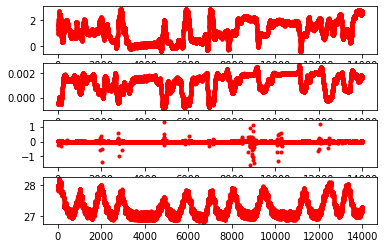

In [6]:
test_radar_signal()